In [2]:
from src.utils.helpers import log_message
from src.config.settings import get_config
# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

import argparse
from typing import List, Tuple, Dict, Optional, Union

import cv2
import numpy as np
import onnxruntime as ort
import torch
import os
from ultralytics.utils import ASSETS, yaml_load
from ultralytics.utils.checks import check_requirements, check_yaml


g:\Software\anaconda\envs\gcxl2025\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:

class Detector:
    """
    Base class for object detection models.

    This class provides the interface and common functionality for object
    detection implementations.

    Attributes:
        confidence_thres (float): Confidence threshold for filtering detections.
        iou_thres (float): IoU threshold for non-maximum suppression.
    """

    def __init__(self, confidence_thres: float = 0.5, iou_thres: float = 0.5):
        """
        Initialize the base Detector class.

        Args:
            confidence_thres (float): Confidence threshold for filtering detections.
            iou_thres (float): IoU threshold for non-maximum suppression.
        """
        self.confidence_thres = confidence_thres
        self.iou_thres = iou_thres
        log_message("初始化检测器")

    def detect(self, image: np.ndarray, confidence: Optional[float] = None) -> List[Dict]:
        """
        Detect objects in the input image.

        Args:
            image (np.ndarray): Input image for detection
            confidence (float, optional): Override default confidence threshold

        Returns:
            List[Dict]: List of detection results with keys:
                - 'box': [x, y, w, h] format bounding box
                - 'score': confidence score
                - 'class_id': class identifier
        """
        raise NotImplementedError("子类必须实现检测方法")

    def visualize_detections(self, image: np.ndarray, detections: List[Dict]) -> np.ndarray:
        """
        Draw detection results on the image.

        Args:
            image (np.ndarray): Input image
            detections (List[Dict]): Detection results from detect() method

        Returns:
            np.ndarray: Image with drawn detections
        """
        raise NotImplementedError("子类必须实现可视化方法")


class YOLOv8(Detector):
    """
    YOLOv8 object detection model class for handling inference and visualization.

    This class provides functionality to load a YOLOv8 ONNX model, perform inference on images,
    and visualize the detection results.

    Attributes:
        onnx_model (str): Path to the ONNX model file.
        confidence_thres (float): Confidence threshold for filtering detections.
        iou_thres (float): IoU threshold for non-maximum suppression.
        classes (List[str]): List of class names from the COCO dataset.
        color_palette (np.ndarray): Random color palette for visualizing different classes.
        input_width (int): Width dimension of the model input.
        input_height (int): Height dimension of the model input.
    """

    def __init__(self, onnx_model: str, confidence_thres: float = 0.5, iou_thres: float = 0.5):
        """
        Initialize an instance of the YOLOv8 class.

        Args:
            onnx_model (str): Path to the ONNX model.
            confidence_thres (float): Confidence threshold for filtering detections.
            iou_thres (float): IoU threshold for non-maximum suppression.
        """
        super().__init__(confidence_thres, iou_thres)
        self.onnx_model = onnx_model
        self.input_width = 640  # Default, will be updated from model
        self.input_height = 640  # Default, will be updated from model

        # Load config to get class names and colors
        config = get_config()

        # Try to load class names from config, fallback to COCO dataset if not found
        try:
            self.classes = config['model']['classes']
            self.class_list = [self.classes.get(str(i), f"class_{i}") for i in range(len(self.classes))]
            log_message(f"从配置文件加载了 {len(self.class_list)} 个类别")
        except (KeyError, TypeError):
            # Fallback to COCO dataset
            log_message("未找到配置中的类别，使用COCO默认类别")
            self.classes = yaml_load(check_yaml("coco8.yaml"))["names"]
            self.class_list = self.classes

        # Define colors for each class - with specific colors for known categories
        self.color_palette = self._generate_color_palette()

        # Initialize model session
        self._initialize_model()

    def _generate_color_palette(self) -> Dict[int, Tuple[int, int, int]]:
        """Generate color palette for visualization with special handling for known colors"""
        colors = {}
        # Generate random colors as fallback
        random_colors = np.random.uniform(0, 255, size=(len(self.classes), 3))

        # Assign specific colors based on class name patterns
        for i in range(len(self.classes)):
            class_name = self.class_list[i].lower()

            if "red" in class_name:
                colors[i] = (0, 0, 255)  # BGR: Red
            elif "blue" in class_name:
                colors[i] = (255, 0, 0)  # BGR: Blue
            elif "green" in class_name:
                colors[i] = (0, 255, 0)  # BGR: Green
            else:
                # Use random color for other classes
                colors[i] = tuple(map(int, random_colors[i]))

        return colors

    def _initialize_model(self):
        """Initialize the ONNX model session and set input dimensions."""
        # 配置推理选项以优化性能
        session_options = ort.SessionOptions()

        # 启用图形优化
        session_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL

        # 启用内存模式优化
        session_options.enable_mem_pattern = True

        # 启用并行推理 (根据CPU核心数量)
        session_options.intra_op_num_threads = 2
        # Create an inference session using the ONNX model and specify execution providers
        self.session = ort.InferenceSession(
            self.onnx_model,
            sess_options=session_options,
            providers=["CPUExecutionProvider"]
        )

        # Get the model inputs and set dimensions
        model_inputs = self.session.get_inputs()
        input_shape = model_inputs[0].shape
        self.input_width = input_shape[2]
        self.input_height = input_shape[3]
        self.model_input_name = model_inputs[0].name

        log_message(f"YOLO模型初始化完成，输入尺寸: {self.input_width}x{self.input_height}")

    def letterbox(self, img: np.ndarray, new_shape: Tuple[int, int] = (640, 640)) -> Tuple[np.ndarray, Tuple[int, int]]:
        """
        Resize and reshape images while maintaining aspect ratio by adding padding.

        Args:
            img (np.ndarray): Input image to be resized.
            new_shape (Tuple[int, int]): Target shape (height, width) for the image.

        Returns:
            (np.ndarray): Resized and padded image.
            (Tuple[int, int]): Padding values (top, left) applied to the image.
        """
        shape = img.shape[:2]  # current shape [height, width]

        # Scale ratio (new / old)
        r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])

        # Compute padding
        new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
        dw, dh = (new_shape[1] - new_unpad[0]) / 2, (new_shape[0] - new_unpad[1]) / 2  # wh padding

        if shape[::-1] != new_unpad:  # resize
            img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
        top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
        left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
        img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(114, 114, 114))

        return img, (top, left)

    def draw_detections(self, img: np.ndarray, box: List[float], score: float, class_id: int) -> None:
        """
        Draw bounding boxes and labels on the input image based on the detected objects.

        Args:
            img (np.ndarray): The input image to draw detections on.
            box (List[float]): Detected bounding box coordinates [x, y, width, height].
            score (float): Confidence score of the detection.
            class_id (int): Class ID for the detected object.
        """
        # Extract the coordinates of the bounding box
        x1, y1, w, h = box

        # Retrieve the color for the class ID
        color = self.color_palette[class_id]

        # Draw the bounding box on the image
        cv2.rectangle(img, (int(x1), int(y1)), (int(x1 + w), int(y1 + h)), color, 2)

        # Create the label text with class name and score
        label = f"{self.class_list[class_id]}: {score:.2f}"

        # Calculate the dimensions of the label text
        (label_width, label_height), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)

        # Calculate the position of the label text
        label_x = x1
        label_y = y1 - 10 if y1 - 10 > label_height else y1 + 10

        # Draw a filled rectangle as the background for the label text
        cv2.rectangle(
            img, (label_x, label_y - label_height), (label_x + label_width, label_y + label_height), color, cv2.FILLED
        )

        # Draw the label text on the image
        cv2.putText(img, label, (label_x, label_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    def preprocess(self, img: np.ndarray) -> Tuple[np.ndarray, Tuple[int, int]]:
        """
        Preprocess the input image before performing inference.

        This method converts color space, applies letterboxing to maintain aspect ratio,
        normalizes pixel values, and prepares the image data for model input.

        Args:
            img (np.ndarray): Input BGR image (OpenCV format)

        Returns:
            (np.ndarray): Preprocessed image data ready for inference with shape (1, 3, height, width).
            (Tuple[int, int]): Padding values (top, left) applied during letterboxing.
        """
        # Convert the image color space from BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Apply letterboxing to resize the image while maintaining aspect ratio
        resized_img, pad = self.letterbox(img_rgb, (self.input_width, self.input_height))

        # Normalize the image data by dividing it by 255.0
        image_data = np.array(resized_img) / 255.0

        # Transpose the image to have the channel dimension as the first dimension
        image_data = np.transpose(image_data, (2, 0, 1))  # Channel first

        # Expand the dimensions of the image data to match the expected input shape
        image_data = np.expand_dims(image_data, axis=0).astype(np.float32)

        # Return the preprocessed image data
        return image_data, pad

    def postprocess(self, original_img: np.ndarray, output: List[np.ndarray], pad: Tuple[int, int]) -> List[Dict]:
        """
        Process the model's output to extract detection information.

        Args:
            original_img (np.ndarray): The original input image.
            output (List[np.ndarray]): The output arrays from the model.
            pad (Tuple[int, int]): Padding values (top, left) used during letterboxing.

        Returns:
            List[Dict]: List of detection results with keys 'box', 'score', and 'class_id'.
        """
        # Transpose and squeeze the output to match the expected shape
        outputs = np.transpose(np.squeeze(output[0]))

        # Get the number of rows in the outputs array
        rows = outputs.shape[0]

        # Lists to store the bounding boxes, scores, and class IDs of the detections
        boxes = []
        scores = []
        class_ids = []

        img_height, img_width = original_img.shape[:2]

        # Calculate the scaling factors for the bounding box coordinates
        gain = min(self.input_height / img_height, self.input_width / img_width)
        outputs[:, 0] -= pad[1]
        outputs[:, 1] -= pad[0]

        # Iterate over each row in the outputs array
        for i in range(rows):
            # Extract the class scores from the current row
            classes_scores = outputs[i][4:]

            # Find the maximum score among the class scores
            max_score = np.amax(classes_scores)

            # If the maximum score is above the confidence threshold
            if max_score >= self.confidence_thres:
                # Get the class ID with the highest score
                class_id = np.argmax(classes_scores)

                # Extract the bounding box coordinates from the current row
                x, y, w, h = outputs[i][0], outputs[i][1], outputs[i][2], outputs[i][3]

                # Calculate the scaled coordinates of the bounding box
                left = int((x - w / 2) / gain)
                top = int((y - h / 2) / gain)
                width = int(w / gain)
                height = int(h / gain)

                # Add the class ID, score, and box coordinates to the respective lists
                class_ids.append(class_id)
                scores.append(max_score)
                boxes.append([left, top, width, height])

        # Apply non-maximum suppression to filter out overlapping bounding boxes
        indices = cv2.dnn.NMSBoxes(boxes, scores, self.confidence_thres, self.iou_thres)

        # Create the list of detection results
        detections = []
        for i in indices:
            detections.append({
                'box': boxes[i],
                'score': scores[i],
                'class_id': class_ids[i]
            })

        return detections

    def detect(self, image: np.ndarray, confidence: Optional[float] = None) -> List[Dict]:
        """
        Detect objects in the input image.

        Args:
            image (np.ndarray): Input image for detection
            confidence (float, optional): Override default confidence threshold

        Returns:
            List[Dict]: List of detection results with keys:
                - 'box': [x, y, w, h] format bounding box
                - 'score': confidence score
                - 'class_id': class identifier
        """
        # Save original confidence and update if needed
        original_confidence = self.confidence_thres
        if confidence is not None:
            self.confidence_thres = confidence

        try:
            # Preprocess the image
            img_data, pad = self.preprocess(image)

            # Run inference
            outputs = self.session.run(None, {self.model_input_name: img_data})

            # Postprocess the outputs
            detections = self.postprocess(image, outputs, pad)

            return detections
        finally:
            # Restore original confidence threshold
            if confidence is not None:
                self.confidence_thres = original_confidence

    def visualize_detections(self, image: np.ndarray, detections: List[Dict]) -> np.ndarray:
        """
        Draw detection results on the image.

        Args:
            image (np.ndarray): Input image
            detections (List[Dict]): Detection results from detect() method

        Returns:
            np.ndarray: Image with drawn detections
        """
        # Create a copy of the image to avoid modifying the original
        result_image = image.copy()

        # Draw each detection on the image
        for detection in detections:
            self.draw_detections(
                result_image,
                detection['box'],
                detection['score'],
                detection['class_id']
            )

        return result_image

    def detect_camera(self, camera_id=0, confidence: Optional[float] = None, display: bool = True) -> None:
        """
        Real-time object detection using camera feed.

        Args:
            camera_id (int): Camera device index
            confidence (float, optional): Override default confidence threshold
            display (bool): Whether to display the results in a window

        Returns:
            None
        """
        # Initialize video capture
        cap = cv2.VideoCapture(camera_id)

        if not cap.isOpened():
            log_message(f"无法打开摄像头 {camera_id}")
            return

        # Variables for FPS calculation
        frame_count = 0
        start_time = cv2.getTickCount()
        fps = 0

        log_message(f"开始摄像头检测，按'q'退出")

        while True:
            # Read frame
            ret, frame = cap.read()
            if not ret:
                log_message("无法读取摄像头帧")
                break

            # Detect objects
            detections = self.detect(frame, confidence)

            # Draw detections
            result_frame = self.visualize_detections(frame, detections)

            # Calculate and display FPS
            frame_count += 1
            if frame_count >= 10:  # Update FPS every 10 frames
                current_time = cv2.getTickCount()
                elapsed_time = (current_time - start_time) / cv2.getTickFrequency()
                fps = frame_count / elapsed_time
                frame_count = 0
                start_time = current_time

            # Add FPS text
            cv2.putText(result_frame, f"FPS: {fps:.1f}", (20, 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # Display number of detections
            cv2.putText(result_frame, f"Detect: {len(detections)}", (20, 80),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            if display:
                cv2.imshow("YOLOv8 Camera Detection", result_frame)

            # Exit on 'q' press
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # Release resources
        cap.release()
        if display:
            cv2.destroyAllWindows()

        log_message("摄像头检测结束")


In [10]:
# 相机检测函数 - Jupyter版本
def detect_camera_jupyter(detector, camera_id=0, confidence=None):
    """
    在Jupyter中运行的实时对象检测函数

    Args:
        detector: 检测器实例
        camera_id (int): 相机设备索引
        confidence (float, optional): 覆盖默认置信度阈值
    """
    from IPython.display import clear_output, display
    import matplotlib.pyplot as plt
    import time

    # 初始化视频捕获
    cap = cv2.VideoCapture(camera_id)

    if not cap.isOpened():
        print(f"无法打开摄像头 {camera_id}")
        return

    print("相机检测启动中...")
    print("按下运行单元格的终止按钮停止检测")

    plt.figure(figsize=(12, 8))

    try:
        while True:
            # 读取帧
            ret, frame = cap.read()
            if not ret:
                print("无法读取摄像头帧")
                break

            # 检测物体
            detections = detector.detect(frame, confidence)

            # 绘制检测结果
            result_frame = detector.visualize_detections(frame, detections)

            # 显示检测数量
            cv2.putText(result_frame, f"检测到: {len(detections)}", (20, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

            # 显示结果
            clear_output(wait=True)
            plt.imshow(cv2.cvtColor(result_frame, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            display(plt.gcf())

            # 短暂休眠以更新显示
            time.sleep(0.1)

    except KeyboardInterrupt:
        print("检测已停止")
    finally:
        # 释放资源
        cap.release()
        print("相机检测结束")

# 使用示例
# detect_camera_jupyter(detector, camera_id=0)

In [11]:
# 导入必要的库
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image

# 创建检测器实例
model_path = "../models/0414-model2/train/weights/best.onnx"  # 调整为实际模型路径
detector = YOLOv8(model_path, confidence_thres=0.5, iou_thres=0.5)

# 加载图像并进行检测
image_path = "../20250309_112823_094.jpg"  # 调整为实际图像路径
image = cv2.imread(image_path)

[2025-04-15 09:27:48] [INFO] 初始化检测器
加载配置文件: config\config.json
[2025-04-15 09:27:48] [INFO] 未找到配置中的类别，使用COCO默认类别
[2025-04-15 09:27:48] [INFO] YOLO模型初始化完成，输入尺寸: 640x640


g:\Software\anaconda\envs\gcxl2025\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26816 (\N{CJK UNIFIED IDEOGRAPH-68C0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
g:\Software\anaconda\envs\gcxl2025\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
g:\Software\anaconda\envs\gcxl2025\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21040 (\N{CJK UNIFIED IDEOGRAPH-5230}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
g:\Software\anaconda\envs\gcxl2025\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20010 (\N{CJK UNIFIED IDEOGRAPH-4E2A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
g:\Software\anaconda\envs\gcxl2025\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23545 (\N{CJK UNIFIE

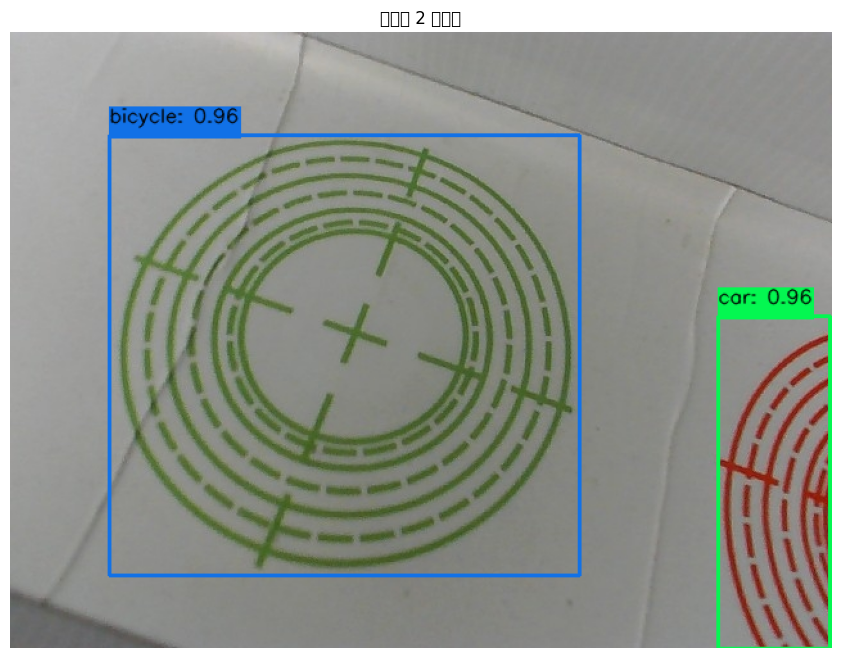

检测到 2 个对象:
  1. car: 置信度 0.96, 位置 [551, 221, 87, 259]
  2. bicycle: 置信度 0.96, 位置 [77, 80, 366, 343]


In [12]:

if image is None:
    print(f"无法加载图像: {image_path}")
else:
    # 执行检测
    detections = detector.detect(image)

    # 可视化检测结果
    result_image = detector.visualize_detections(image, detections)

    # 将BGR转换为RGB以便在matplotlib中正确显示
    result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

    # 显示结果
    plt.figure(figsize=(12, 8))
    plt.imshow(result_image_rgb)
    plt.title(f"检测到 {len(detections)} 个对象")
    plt.axis('off')
    plt.show()

    # 打印检测结果
    print(f"检测到 {len(detections)} 个对象:")
    for i, det in enumerate(detections):
        class_id = det['class_id']
        class_name = detector.class_list[class_id]
        score = det['score']
        box = det['box']
        print(f"  {i+1}. {class_name}: 置信度 {score:.2f}, 位置 {box}")